# MOVIE REVIEW SENTIMENTAL CLASSIFICATION

*GOAL*: The objective of this challenge is to, given a sentence, classify whether the sentence is of positive, negative, or neutral sentiment. For messages conveying both a positive and negative sentiment, whichever is the stronger sentiment should be chosen. Predict if the text would be considered positive, negative, or neutral for an average user

# Imported Libraries

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [7]:
train = pd.read_csv('/content/drive/MyDrive/Train (1).csv')
test = pd.read_csv('/content/drive/MyDrive/Test (2).csv')
submission = pd.read_csv('/content/drive/MyDrive/SampleSubmission (1).csv')

In [8]:
train.head()

,review_file,content,sentiment
0,3471_8.txt,Recently shown on cable tv the movie opens wit...,positive
1,9693_8.txt,I was very surprised with this film. I was tou...,positive
2,10801_1.txt,"Now, I'm one to watch movies that got poor rev...",negative
3,9592_8.txt,"This film came out 12 years years ago, and was...",positive
4,8514_7.txt,"When an orphanage manager goes on vacation, hi...",positive


In [9]:
test.head()

,review_file,content
0,0_10.txt,I went and saw this movie last night after bei...
1,0_2.txt,Once again Mr. Costner has dragged out a movie...
2,10000_4.txt,This is an example of why the majority of acti...
3,10000_7.txt,Actor turned director Bill Paxton follows up h...
4,10001_1.txt,"First of all I hate those moronic rappers, who..."


In [10]:
submission.tail()

,review_file,sentiment
24995,999_8.txt,negative
24996,99_10.txt,negative
24997,99_3.txt,negative
24998,9_4.txt,negative
24999,9_7.txt,negative


# Preprocessing for both train and test dataset

In [11]:
train.isnull().sum()

review_file    0
content        0
sentiment      0
dtype: int64

In [12]:
# Map sentiment labels to numerical values
sentiment_mapping = {'positive': 1, 'negative': 0}
train['sentiment'] = train['sentiment'].map(sentiment_mapping)

In [13]:
# Convert text to lowercase and remove special characters
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

In [14]:
train['content'] = train['content'].apply(clean_text)
test['content'] = test['content'].apply(clean_text)

In [15]:
# Split data into input text and sentiment label
X = train['content'].values
y = train['sentiment'].values

# test data into input text
test_df = test['content'].values

In [16]:
# Tokenize the text data
max_words = 25000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)

In [18]:
# Save the tokenizer to a file using pickle
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Tokenize and pad the train and test data
X_sequences = tokenizer.texts_to_sequences(X)
test_sequences = tokenizer.texts_to_sequences(test_df)

In [ ]:
# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
max_sequence_length = 200
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')


In [ ]:
# Convert to TensorFlow tensors
X_tensor = tf.constant(X_padded, dtype=tf.int32)
y_tensor = tf.constant(y, dtype=tf.int32)

# Create a tf.data.Dataset from tensors
dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))



In [ ]:
# Split the data into training and testing sets
train_data = int(0.75 * len(dataset))
eval_data = len(dataset) - train_data

In [ ]:
train_dataset = dataset.take(train_data)
eval_dataset = dataset.skip(train_data)

# Shuffle and batch the training dataset
batch_size = 70
train = train_dataset.shuffle(buffer_size=train_data).batch(batch_size)
eval = eval_dataset.shuffle(buffer_size=eval_data).batch(batch_size)


## Model Building

In [ ]:
# Build the LSTM Recurrent Neural Network
embedding_dim = 100
lstm_units = 64

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=lstm_units))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer with binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          12130300  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,174,653
Trainable params: 12,174,653
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Train/model'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model = model.fit(
    train,
    validation_data=eval,
    epochs=10,
    callbacks=[model_checkpoint])

Epoch 1/10
268/268 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.5939

268/268 [==============================] - 159s 583ms/step - loss: 0.6496 - accuracy: 0.5939 - val_loss: 0.4305 - val_accuracy: 0.8258
Epoch 2/10
268/268 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8329

268/268 [==============================] - 149s 557ms/step - loss: 0.4462 - accuracy: 0.8329 - val_loss: 0.4261 - val_accuracy: 0.8408
Epoch 3/10
268/268 [==============================] - 151s 563ms/step - loss: 0.4323 - accuracy: 0.8301 - val_loss: 0.6202 - val_accuracy: 0.6680
Epoch 4/10
268/268 [==============================] - 157s 584ms/step - loss: 0.5327 - accuracy: 0.7548 - val_loss: 0.7404 - val_accuracy: 0.6091
Epoch 5/10
268/268 [==============================] - 151s 563ms/step - loss: 0.4908 - accuracy: 0.7748 - val_loss: 0.5832 - val_accuracy: 0.7522
Epoch 6/10
268/268 [==============================] - 149s 555ms/step - loss: 0.5251 - accuracy: 0.7316 - val_loss: 0.6408 - val_accuracy: 0.5795
Epoch 7/10
268/268 [==============================] - 157s 586ms/step - loss: 0.5279 - accuracy: 0.7014 - val_loss: 0.6175 - val_accuracy: 0.5770
Epoch 8/10
268/268 [==============================] - 153s 571ms/step - loss: 0.4908 - accuracy: 0.7606 - val_loss: 0.5811 - val_accura

### Graphical representation of validation loss and accuracy

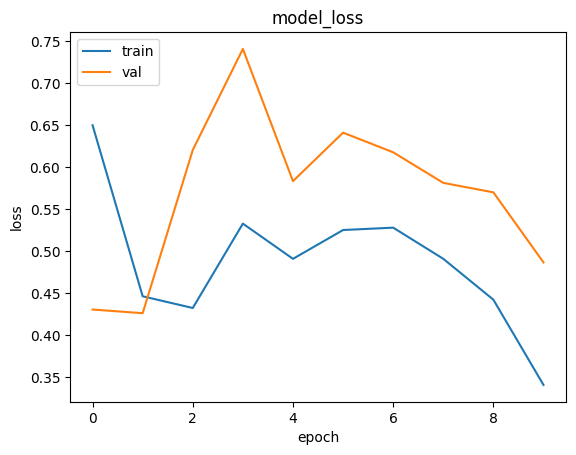

In [ ]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

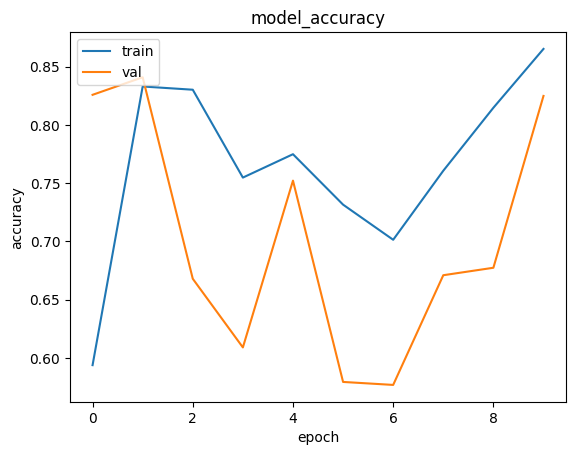

In [ ]:
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Pediction on the test dataset

In [ ]:
# Load the model from the saved file
loaded_model = load_model("/content/drive/MyDrive/Train/model")



In [ ]:
predictions = loaded_model.predict(test_padded)

782/782 [==============================] - 32s 40ms/step


In [ ]:
# Convert predictions to sentiment labels
predicted_labels = [list(sentiment_mapping.keys())[list(label).index(max(label))] for label in predictions]


In [ ]:
# Add predicted labels to the test prediction data and save to a new CSV file
test["sentiment"] = predicted_labels

In [ ]:
# drop content column
col = 'content'
submission = test.drop(col, axis=1)

In [ ]:
submission.head()

,review_file,sentiment
0,0_10.txt,positive
1,0_2.txt,positive
2,10000_4.txt,positive
3,10000_7.txt,positive
4,10001_1.txt,positive


In [ ]:
# save the file
submission.to_csv("test_prediction_with_labels.csv", index=False)